<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Merge-samples" data-toc-modified-id="Merge-samples-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Merge samples</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Load-data-and-preprocess" data-toc-modified-id="Load-data-and-preprocess-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data and preprocess</a></span></li><li><span><a href="#Create-metadata" data-toc-modified-id="Create-metadata-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Create metadata</a></span></li><li><span><a href="#Reduce-dimensions" data-toc-modified-id="Reduce-dimensions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Reduce dimensions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li></ul></div>

# Imports

You should consider upgrading via the 'c:\users\stéphane\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Using legacy setup.py install for umap-learn, since package 'wheel' is not installed.
Using legacy setup.py install for future, since package 'wheel' is not installed.
Using legacy setup.py install for wrapt, since package 'wheel' is not installed.
    Running setup.py install for future: started
    Running setup.py install for future: finished with status 'done'
    Running setup.py install for wrapt: started
    Running setup.py install for wrapt: finished with status 'done'
    Running setup.py install for umap-learn: started
    Running setup.py install for umap-learn: finished with status 'done'
  Cloning https://github.com/jacoblevine/phenograph.git to c:\users\stphan~1\appdata\local\temp\pip-req-build-m3y2ag76
Using legacy setup.py install for PhenoGraph, since package 'wheel' is not installed.
    Running setup.py install for PhenoGraph: started
    Running setup.py install for PhenoGraph: finished with status 'done'


  Running command git clone -q https://github.com/jacoblevine/phenograph.git 'C:\Users\STPHAN~1\AppData\Local\Temp\pip-req-build-m3y2ag76'
You should consider upgrading via the 'c:\users\stéphane\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


# Functions

## Preprocess 10X

In [63]:
#' This function takes a data-frame (genes x cells), 
#' creates a Scprep object with it and filters the object for default tags such as  
#' Min and max nFeature_RNA and % of MT
#' 
#'
#' @param data data-frame
#' @param percent_mt integer [0-100]
#' @param max_features integer [0-Inf]
#' @param min_features integer [0-Inf]
#' @return Preprocessed Seurat object
#' @export

def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [3]:
# This function takes the path to a 10X output folder and instanciates the Scprep object
#
# @param file string (path to file)
# @param percent_mt integer [0-100]
# @param max_features integer [0-Inf]
# @param min_features integer [0-Inf]
# @return Preprocessed Seurat object
# @export

def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)


## Reduce dimensions

In [4]:
# This function reduces the dimensions of the Normalized Seurat object
# Runs PCA and then UMAP and then performs clustering

# @param seurat.obj S4 instance
# @param ndims integer [3-100]
# @param res double [0-3]
# @return Seurat object with reduction embeddings
# @export

def reduce_dim(data, ndims=15, res=.1):
    data = scprep.normalize.library_size_normalize(data)
    data = scprep.utils.matrix_transform(data, np.sqrt)


    return data

## Merge samples

In [5]:
# Merge samples 
#
# 
# This function allows to instantiate a merged Seurat object of several distinct samples
# 
#
# @param files character vector of the files to merge 
# @return Merged Seurat object 
# @export

def merge_samples(dir_paths, labels, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    
    # Declare empty array T
    T=[]
    
    #Loading all files
    for dp in dir_paths:
        T.append(scprep.io.load_10X(dp, sparse=True, gene_labels='both'))
        
    #Merge samples
    data, sample_labels = scprep.utils.combine_batches(
        data=T,
        batch_labels=labels,
        append_to_cell_names=True
    )
    
    # Delete T to save space
    for t in T:
        del t

    return preprocess_10X(data, name, percent_mt, max_features, min_features), sample_labels

# Main

## Load data and preprocess

In [6]:

dir_paths = [
    "../data/14_EAE_all_cells.MPS12344479-A02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/15_EAE_all_cells.MPS12344479-B02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix",
    "../data/16_WT_all_cells.MPS12344479-H01.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix"
]

lables = [
    "14_EAE", 
    "15_EAE", 
    "16_WT"
]

data,sample_labels = merge_samples(dir_paths=dir_paths, labels=lables, percent_mt=20, max_features=5000, min_features=200)

# seurat_path = "../../tutorials/seurat_guidedClustering/seurat_clusteringTutorial/filtered_gene_bc_matrices/hg19"
# data = load_10X(dir_path=seurat_path, percent_mt=20, max_features=5000, min_features=200)
data.head()


,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,9.0,5.0,2.0,2.0,1.0,1.0,8.0,0.0,0.0
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,6.0,3.0,0.0,1.0,4.0,1.0,0.0
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,9.0,8.0,4.0,6.0,1.0,3.0,17.0,0.0,1.0
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.0,15.0,10.0,3.0,6.0,0.0,4.0,18.0,2.0,0.0
AAAGATGCAATGACCT-1_14_EAE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,26.0,12.0,20.0,6.0,5.0,1.0,2.0,18.0,3.0,1.0


## Create metadata

In [7]:
sample_labels = pd.Series(sample_labels, index=data.index, name = "sample_labels")

libsize = scprep.measure.library_size(data)
libsize.name='library_size'

metadata = pd.concat([sample_labels, libsize], axis=1)
metadata


,sample_labels,library_size
AAACCTGGTATCGCAT-1_14_EAE,14_EAE,2460.0
AAACGGGAGAACTGTA-1_14_EAE,14_EAE,1154.0
AAACGGGGTTCTCATT-1_14_EAE,14_EAE,3949.0
AAACGGGGTTCTGAAC-1_14_EAE,14_EAE,4312.0
AAAGATGCAATGACCT-1_14_EAE,14_EAE,4120.0
...,...,...
TTTGTCACACGACGAA-1_16_WT,16_WT,4019.0
TTTGTCAGTGGCGAAT-1_16_WT,16_WT,2084.0
TTTGTCATCAGTTAGC-1_16_WT,16_WT,3603.0
TTTGTCATCATATCGG-1_16_WT,16_WT,2399.0


## Reduce dimensions

In [8]:
reduce_dim(data)

,0610005C13Rik (ENSMUSG00000109644),0610009B22Rik (ENSMUSG00000007777),0610009O20Rik (ENSMUSG00000024442),0610010F05Rik (ENSMUSG00000042208),0610010K14Rik (ENSMUSG00000020831),0610012G03Rik (ENSMUSG00000107002),0610025J13Rik (ENSMUSG00000046683),0610030E20Rik (ENSMUSG00000058706),0610037L13Rik (ENSMUSG00000028608),0610038B21Rik (ENSMUSG00000097882),...,mt-Co2 (ENSMUSG00000064354),mt-Co3 (ENSMUSG00000064358),mt-Cytb (ENSMUSG00000064370),mt-Nd1 (ENSMUSG00000064341),mt-Nd2 (ENSMUSG00000064345),mt-Nd3 (ENSMUSG00000064360),mt-Nd4 (ENSMUSG00000064363),mt-Nd4l (ENSMUSG00000065947),mt-Nd5 (ENSMUSG00000064367),mt-Nd6 (ENSMUSG00000064368)
AAACCTGGTATCGCAT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.492151,6.048584,4.508348,2.851330,2.851330,2.016195,2.016195,5.702659,0.000000,0.000000
AAACGGGAGAACTGTA-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,5.887448,6.582367,7.210622,7.210622,5.098680,0.000000,2.943724,5.887448,2.943724,0.000000
AAACGGGGTTCTCATT-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.591316,0.0,0.000000,0.0,0.0,...,4.210226,4.773948,4.500921,3.182632,3.897912,1.591316,2.756240,6.561164,0.000000,1.591316
AAACGGGGTTCTGAAC-1_14_EAE,0.0,0.00000,0.0,0.0,0.000000,1.522862,0.0,0.000000,0.0,0.0,...,5.490758,5.898020,4.815713,2.637675,3.730235,0.000000,3.045725,6.460957,2.153652,0.000000
AAAGATGCAATGACCT-1_14_EAE,0.0,0.00000,0.0,0.0,1.557942,0.000000,0.0,1.557942,0.0,0.0,...,7.943979,5.396871,6.967330,3.816164,3.483665,1.557942,2.203263,6.609790,2.698435,1.557942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACACGACGAA-1_16_WT,0.0,0.00000,0.0,0.0,1.577397,1.577397,0.0,0.000000,0.0,0.0,...,3.527167,1.577397,3.863818,1.577397,1.577397,0.000000,0.000000,4.173400,2.230776,0.000000
TTTGTCAGTGGCGAAT-1_16_WT,0.0,2.19054,0.0,0.0,0.000000,3.794126,0.0,0.000000,0.0,0.0,...,4.898196,3.794126,3.097891,2.190540,0.000000,0.000000,2.190540,3.794126,2.190540,2.190540
TTTGTCATCAGTTAGC-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,3.725228,4.407749,2.885549,1.665973,0.000000,0.000000,0.000000,2.885549,1.665973,0.000000
TTTGTCATCATATCGG-1_16_WT,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,4.565306,4.565306,6.125001,5.401743,5.001042,0.000000,0.000000,6.771443,2.041667,2.041667


## Clustering

In [16]:
data_pca, singular_values = scprep.reduce.pca(data, n_components=100, return_singular_values=True, method='dense')


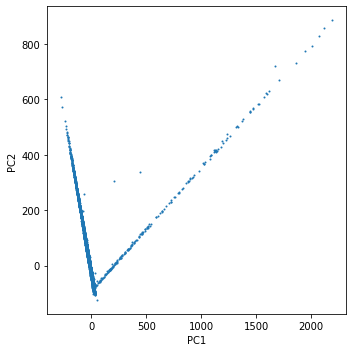

In [17]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.scatter(data_pca.values[:,0], data_pca.values[:,1], s=1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

fig.tight_layout()


<AxesSubplot:xlabel='Principal Component', ylabel='Explained Variance (%)'>

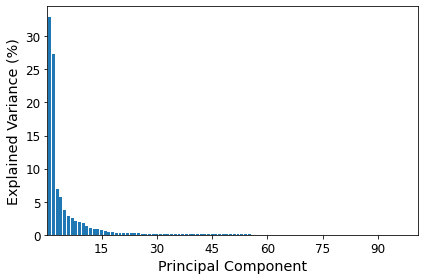

In [18]:
scprep.plot.scree_plot(singular_values)

In [58]:
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 9613 observations and 17684 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 22.47 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.62 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 39.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.44 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.48 seconds.
  Calculated landmark operator in 33.60 seconds.
  Calculating optimal t...
    Automatically selected t = 34
  Calculated optimal t in 5.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.77 seconds.
Calculated PHATE in 87.07 seconds.


In [20]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_pca)

Calculating KMeans...
Calculated KMeans in 1.46 seconds.


In [21]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

In [22]:
with tasklogger.log_task("Louvain"):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights="weight", resolution_parameter=1)
    louvain_clusters = np.array(partition.membership)

Calculating Louvain...
Calculated Louvain in 0.98 seconds.


In [23]:
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=20, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating Spectral clustering...
Calculated Spectral clustering in 5.07 seconds.


In [26]:
clusterings = {'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_phate[:,0])
    clusterings[alg] = cl_nu

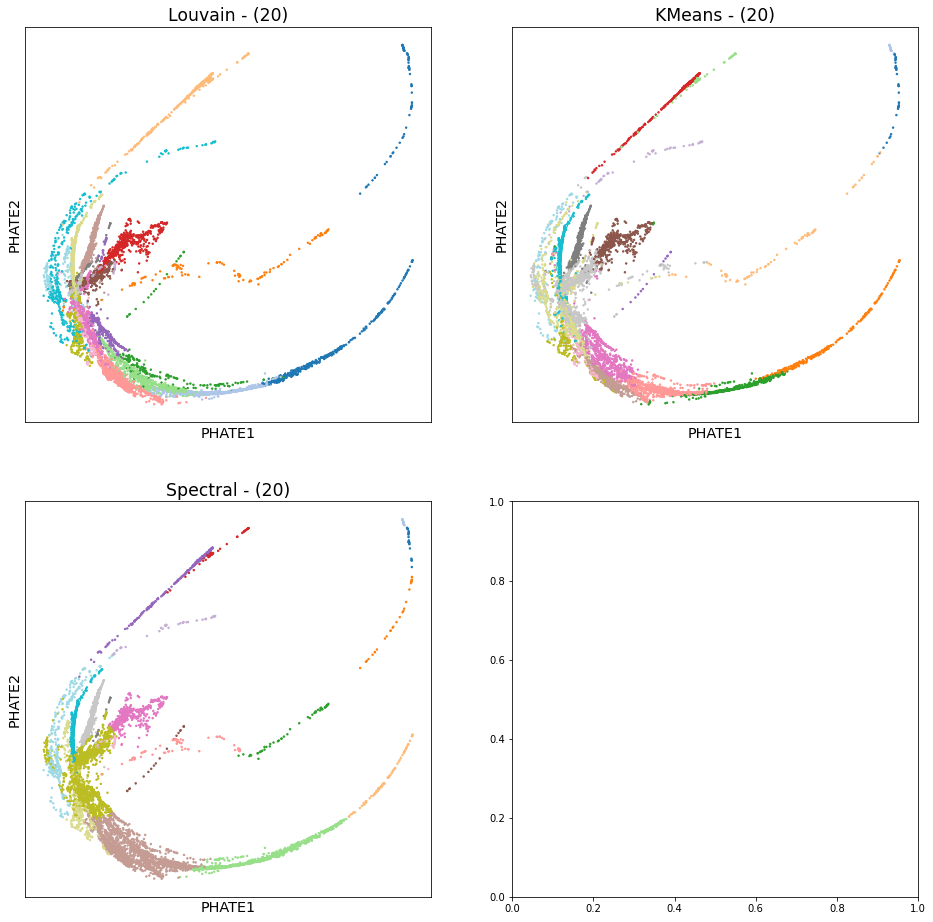

In [27]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algorithm in zip(axes.flatten(), clusterings):
    scprep.plot.scatter2d(data_phate, c=clusterings[algorithm], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algorithm, len(np.unique(clusterings[alg]))), 
                          ticks=False, label_prefix="PHATE", legend=False, discrete=True,
                          ax=ax)

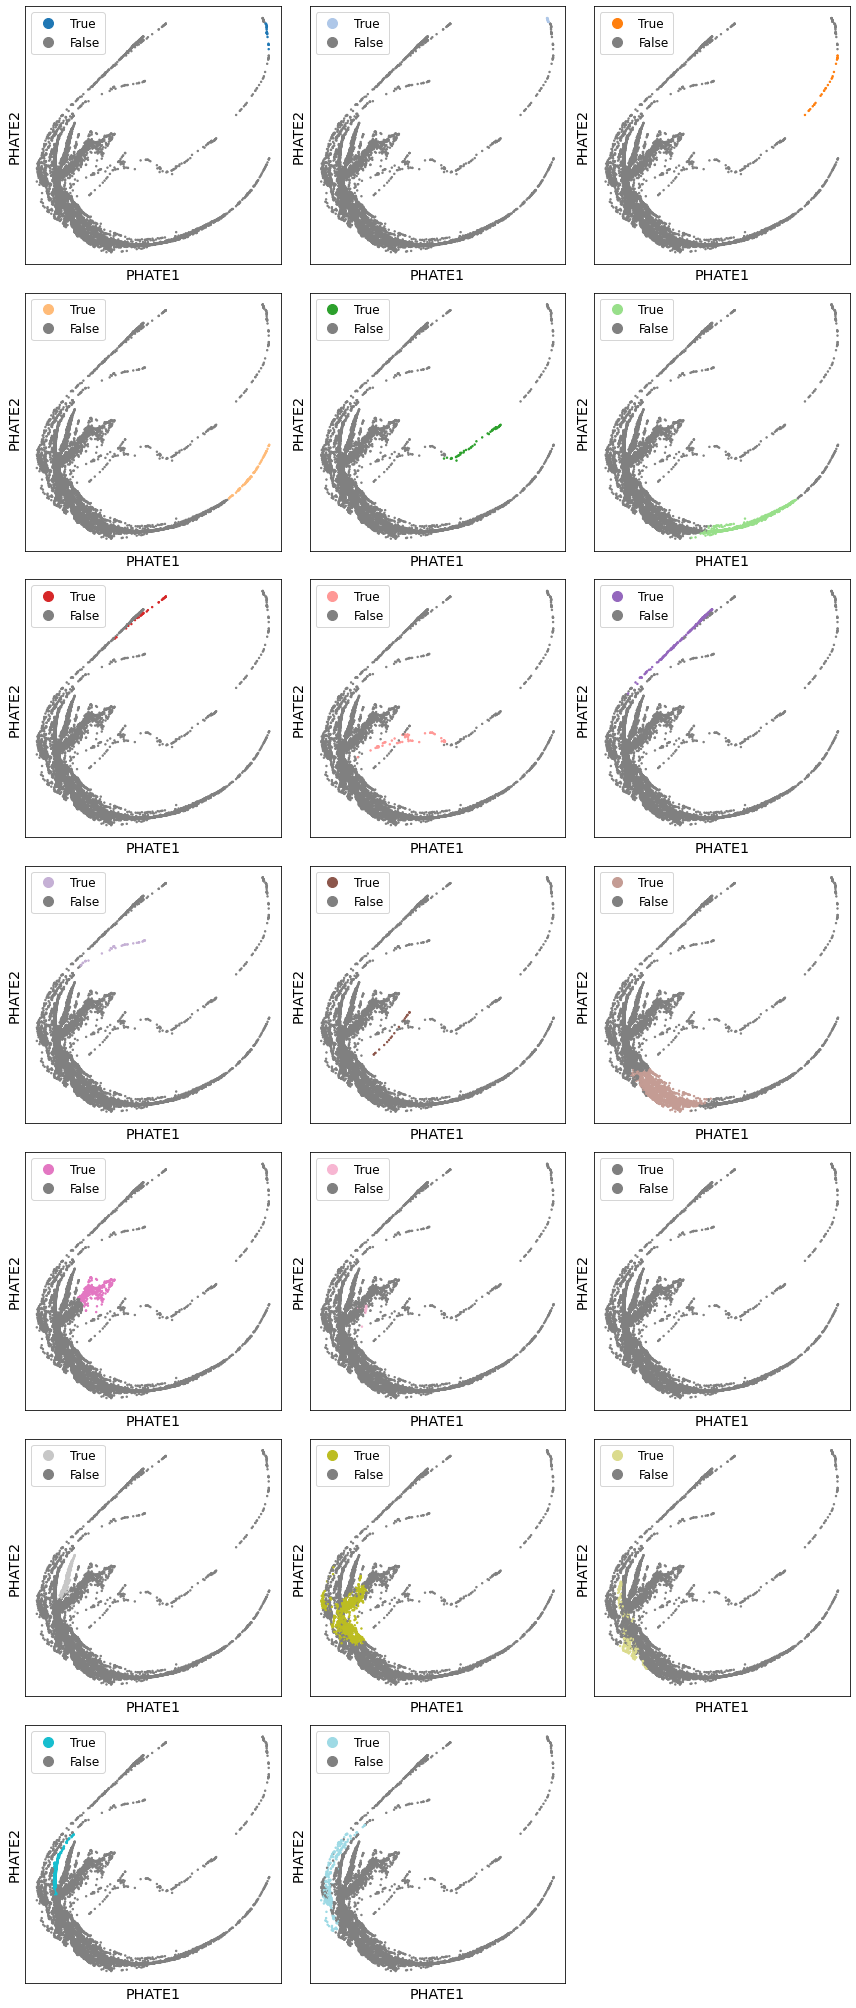

In [29]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()
clusters = clusterings['Spectral']
cluster_ids = np.unique(clusters)
for i in range(len(axes)):
    ax = axes[i]
    try:
        curr_cluster = cluster_ids[i]
        # Returns array([False, True,...,False]) indicating if each cell is in the
        # current cluster
        curr_mask = clusters == curr_cluster  
        scprep.plot.scatter2d(data_phate, c=curr_mask,
                              cmap={True: plt.cm.tab20.colors[i], False: 'grey'},
                              ticks=False, label_prefix='PHATE', ax=ax)
    except IndexError:
        # we have more axes than clusters
        ax.axis('off')


fig.tight_layout()

In [30]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])    
all_clusterings = np.vstack(all_clusterings)

In [32]:
from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
# squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric
# so we need to add 1's on the diagonal with np.eye()
cluster_similarities = cluster_similarities + np.eye(3)

In [57]:
# ==============
# choose your favorite clustering method
# e.g. clusterings['Phenograph'], clusterings['Louvain'], clusterings['KMeans'] or clusterings['Spectral']
clusters = clusterings[ 'KMeans' ]
# ==============

AttributeError: 'numpy.ndarray' object has no attribute 'head'

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\plot\tools.py:255: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  extent=[xmin, xmax, ymin, ymax],


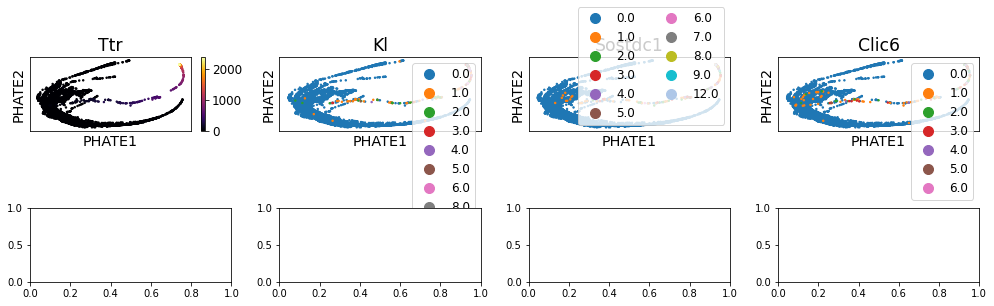

In [72]:

genes_for_plotting = ['Ttr', 'Kl', 'Sostdc1', 'Clic6' ]
fig, axes = plt.subplots(2,len(genes_for_plotting), figsize=(14,4))
for curr_gene, ax in zip(genes_for_plotting, axes.flatten()):
    
    expression = scprep.select.select_cols(data, exact_word=curr_gene)

    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE', ax=ax)

fig.tight_layout()
# np.set_printoptions(threshold=np.inf)
# data.columns.values